In [34]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.time_frequency import tfr_morlet
from mne.io import read_raw_edf


In [35]:
# Path to your EDF file
edf_file_path = 'data/subject_1_fvep_led_training_1.edf'

# Load the EDF file
raw = read_raw_edf(edf_file_path, preload=True)
# Print information about all channels
# print(raw.info['chs'])

# Or for a more readable format
print(raw.info)

Extracting EDF parameters from /Users/pellet/dev/brainhack/ssvep_brainhack/data/subject_1_fvep_led_training_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 57855  =      0.000 ...   225.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 11
 projs: []
 sfreq: 256.0 Hz
 subject_info: 4 items (dict)
>


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
['sample time', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'stim', 'lda classification']
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


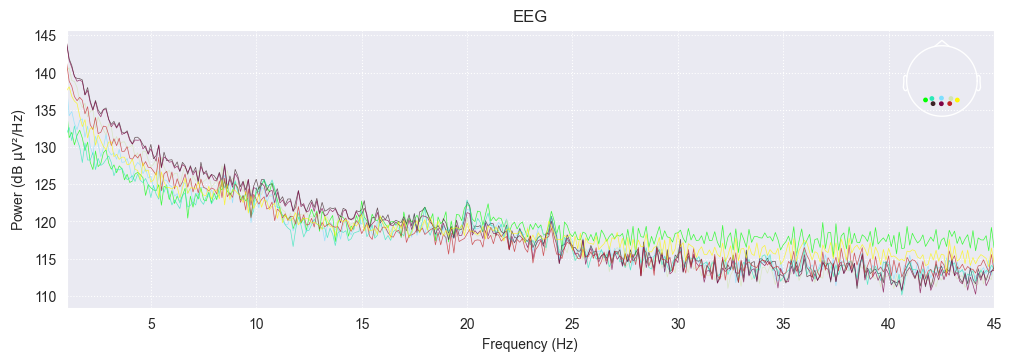

In [36]:
print(raw.ch_names)
# Assign the correct channel names
new_channel_names = ['sample time','PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'stim', 'lda classification']
raw.rename_channels(dict(zip(raw.ch_names, new_channel_names)))

# Set appropriate channel types for non-EEG channels
raw.set_channel_types({
    'sample time': 'misc',  # Miscellaneous channel for timing
    'stim': 'stim',         # Stimulus trigger channel
    'lda classification': 'misc'  # Miscellaneous channel for LDA output
})

raw.set_montage('standard_1020')
print(raw.ch_names)
picks = [1,2,3,4,5,6,7,8]

# capture stimulation frequency and harmonics(including half harmonics)
fmax = 45
raw.plot_psd(fmin=1, fmax=fmax, picks=picks)

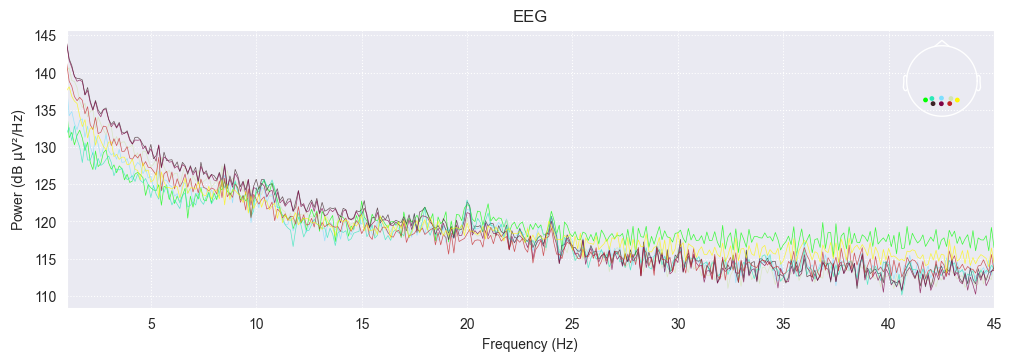

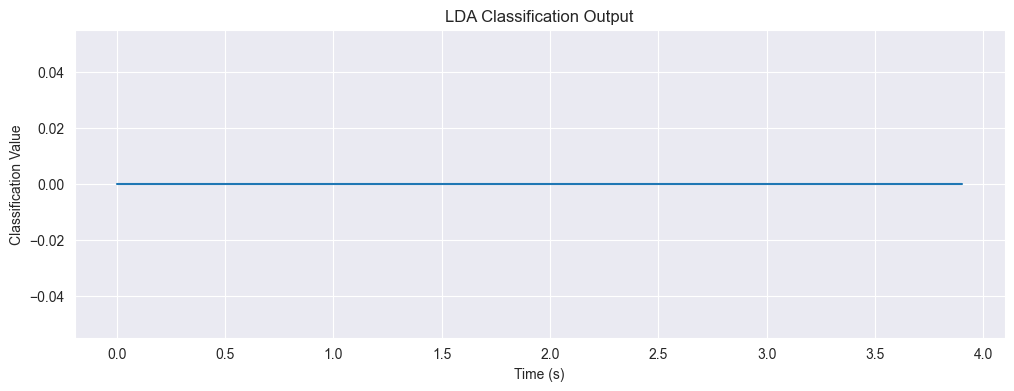

Unique classification values: [0. 3.]
Class 0.0: 51200 samples (88.50%)
Class 3.0: 6656 samples (11.50%)


In [37]:

# Extract the data from the identified channel
lda_output, times = raw['lda classification', :]
lda_output = lda_output.flatten()  # Convert to 1D array

# Plot the LDA classification output
plt.figure(figsize=(12, 4))
plt.plot(times[:1000], lda_output[:1000])  # Plot first 1000 samples
plt.title('LDA Classification Output')
plt.xlabel('Time (s)')
plt.ylabel('Classification Value')
plt.grid(True)
plt.show()

# Analyze the classification values
unique_values = np.unique(lda_output)
print(f"Unique classification values: {unique_values}")

# If the LDA output represents class labels (e.g., 1, 2, 3, 4 for different frequencies)
# you can count occurrences of each class
if len(unique_values) < 10:  # Assuming it's a small set of discrete classes
    for val in unique_values:
        count = np.sum(lda_output == val)
        percentage = (count / len(lda_output)) * 100
        print(f"Class {val}: {count} samples ({percentage:.2f}%)")


## Epoching



In [38]:
# Next, we will chunk (epoch) the data into segments representing the data from the trigger/stim time to 7s after each stimulus.

events = find_events(raw, stim_channel='stim')
events

unique_event_ids = np.unique(events[:, 2])
print("Unique event IDs:", unique_event_ids)


classes = []
for i in range(len(events)):
    if i % 4 == 0:
        events[i][2] = 0
        classes.append(0)
    elif i % 4 == 1:
        events[i][2] = 1
        classes.append(1)
    elif i % 4 == 2:
        events[i][2] = 2
        classes.append(2)
    elif i % 4 == 3:
        events[i][2] = 3
        classes.append(3)

# Method 1: Show unique event IDs
unique_event_ids = np.unique(events[:, 2])
print("Unique event IDs:", unique_event_ids)

event_id = {'9 Hz': 3, '10 Hz': 2, '12 Hz': 1, '15 Hz': 0}
# stimulus is shown for 7 seconds.
tmax = 7
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=0, tmax=tmax, baseline=None, preload=True,
                verbose=False, picks=picks)
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

20 events found on stim channel stim
Event IDs: [1]
Unique event IDs: [1]
Unique event IDs: [0 1 2 3]
sample drop %:  0.0


## Stimuli-Specific PSD



['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
Effective window size : 4.016 (s)
(8, 515)


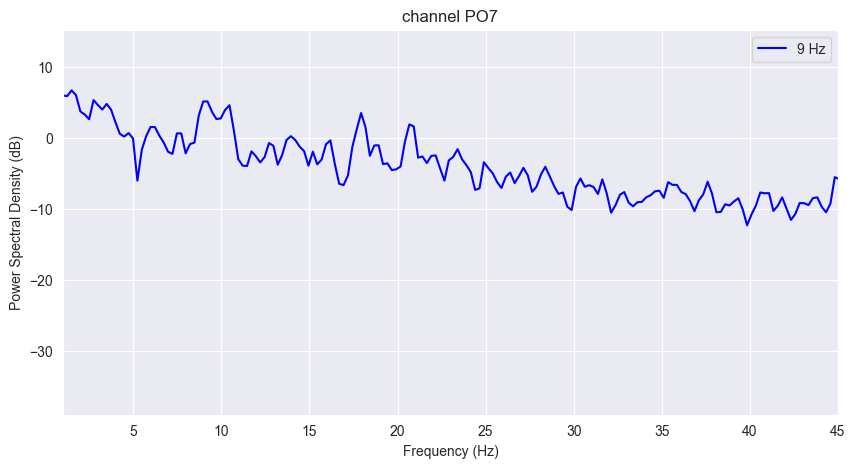

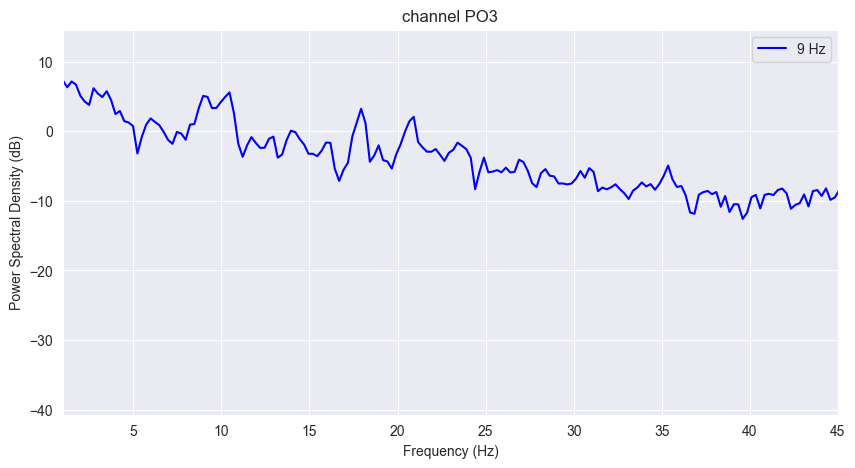

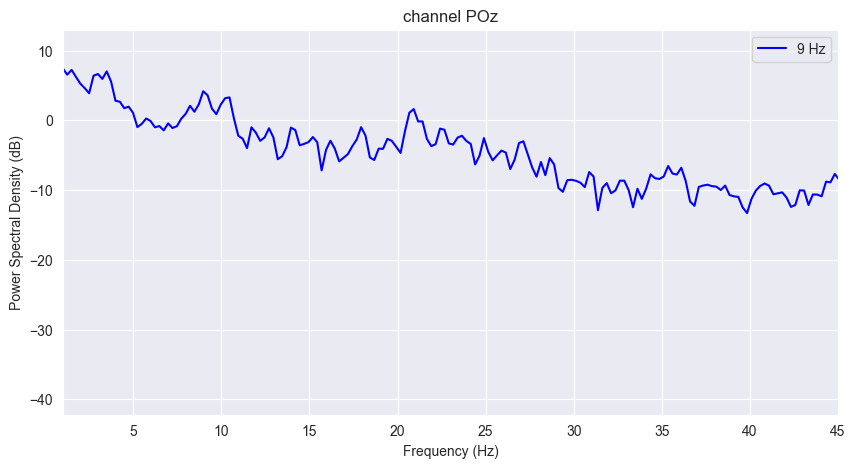

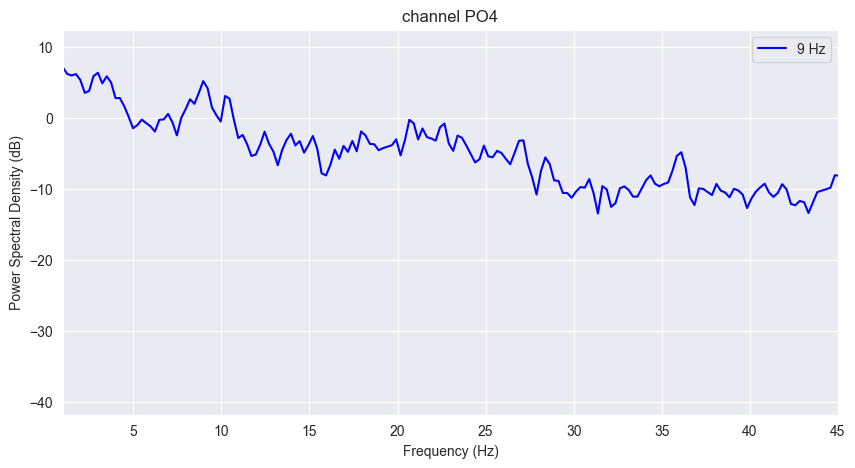

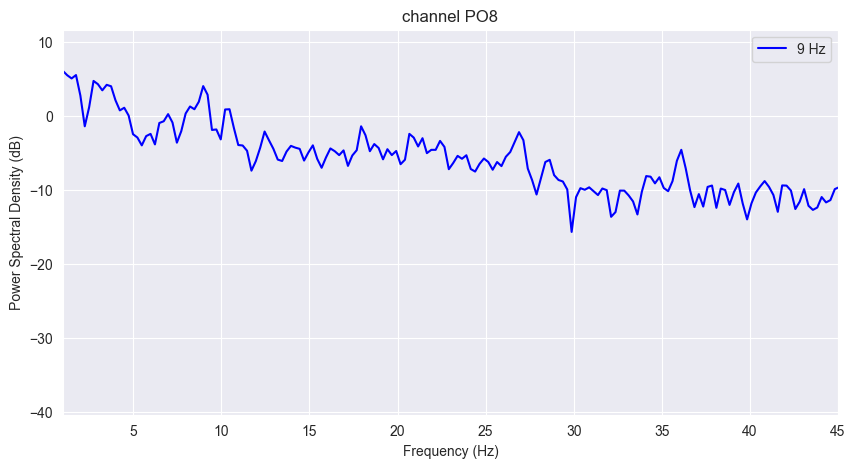

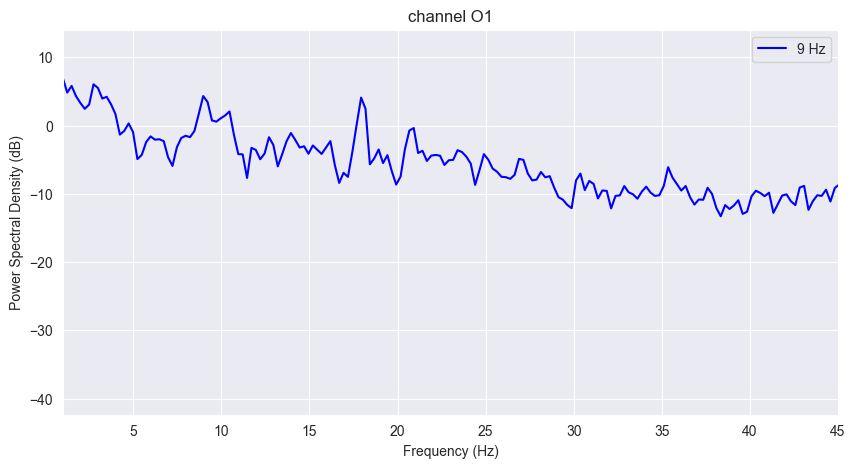

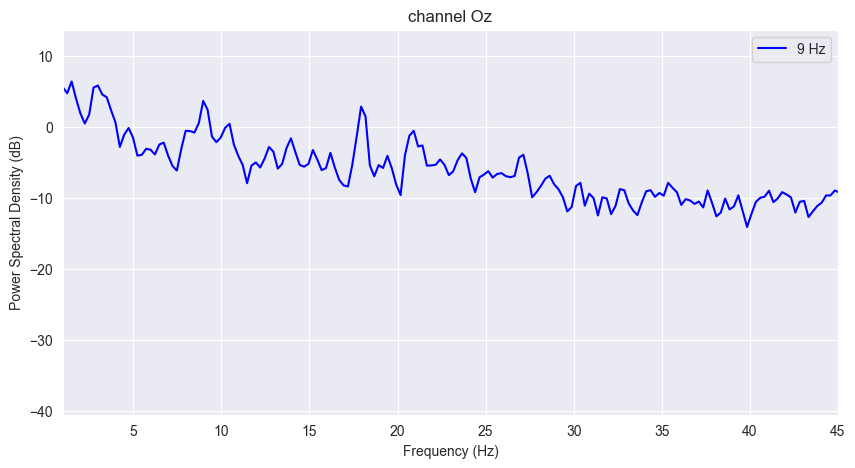

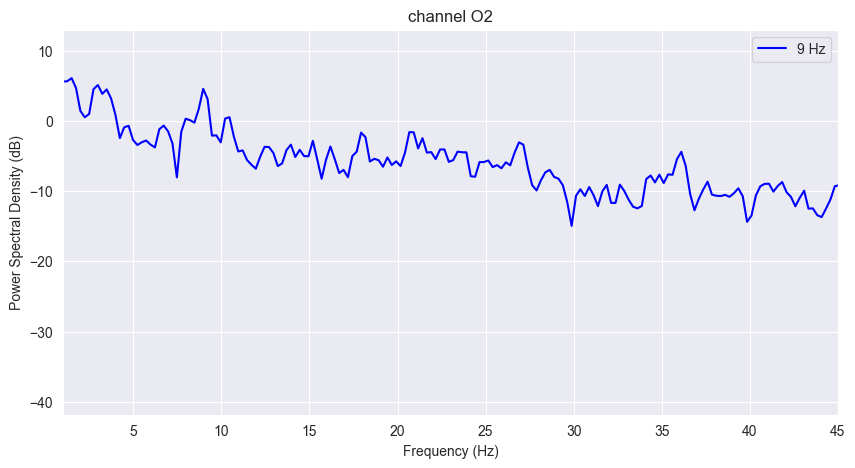

In [39]:
print(epochs.ch_names)

welch_params=dict(method='welch',
                  n_fft=1028,
                  n_per_seg=256 * 3,
                  picks='all')

psd1, freq1 = epochs['9 Hz'].compute_psd(**welch_params).get_data(return_freqs=True)
psd1 = 10 * np.log10(psd1)

psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)
print(psd1_mean.shape)
for i, ch_name in enumerate(epochs.ch_names):
    f, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(freq1, psd1_mean[[i], :].mean(0), color='b', label='9 Hz')
    axs.set_title(f'channel {ch_name}')
    axs.set_ylabel('Power Spectral Density (dB)')
    axs.set_xlim((1, fmax))
    axs.set_xlabel('Frequency (Hz)')
    axs.legend()
    plt.show()


## Spectrogram



NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


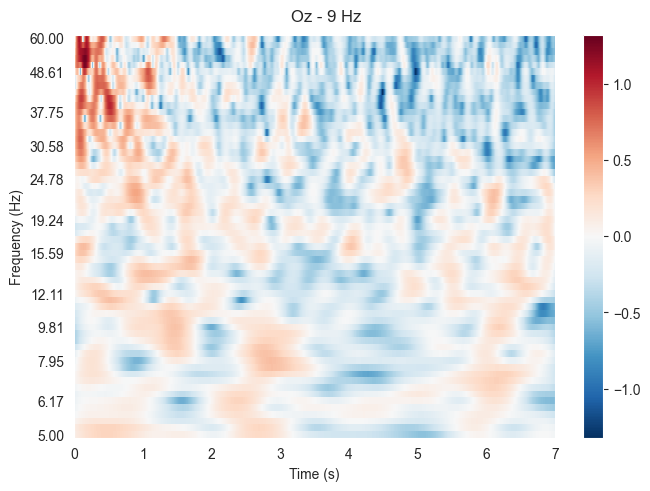

Applying baseline correction (mode: logratio)


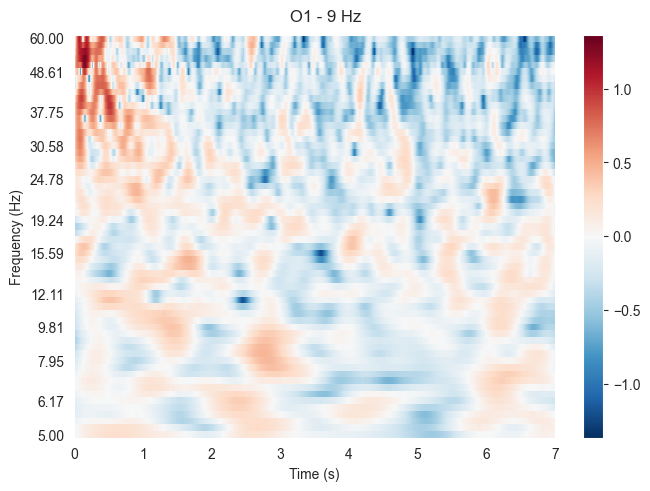

Applying baseline correction (mode: logratio)


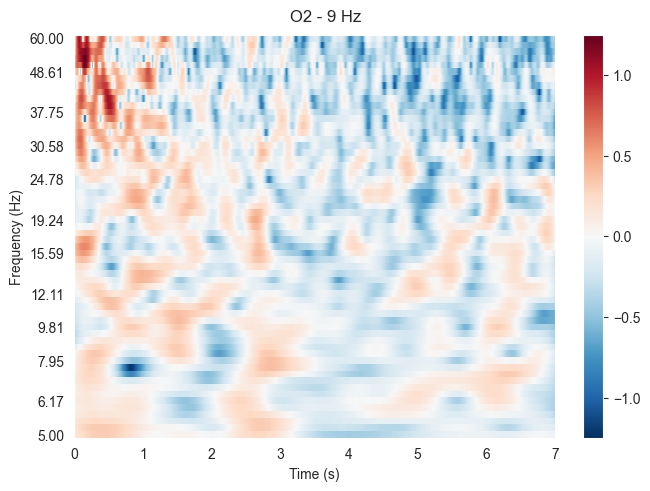

[<Figure size 640x480 with 2 Axes>]

In [40]:
frequencies = np.logspace(np.log10(5), np.log10(60), 60)
tfr, itc = tfr_morlet(epochs['9 Hz'], freqs=frequencies,picks='all',
                              n_cycles=15, return_itc=True)
tfr.plot(picks=['Oz'], baseline=(0, tmax), mode='logratio',
                 title='Oz - 9 Hz')
tfr.plot(picks=['O1'], baseline=(0, tmax), mode='logratio',
                 title='O1 - 9 Hz')
tfr.plot(picks=['O2'], baseline=(0, tmax), mode='logratio',
                 title='O2 - 9 Hz')